In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from src.catalogs import (
    JapanSlowSlipCatalog,
    RoussetSlowSlipCatalog, 
    XieSlowSlipCatalog,
    WilliamsSlowSlipCatalog,
    # MichelSlowSlipCatalog,   # too few earthquakes to estaplish rate changes 
)

from src.data import (
    AllSlabs, 
    Catalog,
    SlowSlipCatalog,
    EarthquakeCatalog,
    Scaling
)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import gaussian_kde, kstest

from typing import Union

import src
from pathlib import Path
base_dir = Path(src.__file__).parents[1]

mpl.rc('figure',dpi=300)
plt.style.use('tableau-colorblind10')
mpl.rc('font',size=8)

# Global analysis of slow slip

## Datasets

`AllSlabs` loads in all the slab geometries from Slab2.0

In [4]:
all_slabs = AllSlabs()

We now load in all the slow slip datasets. Please refer to `Datasets/Slow_slip_datasets` for detailed metadata for each datasets.

In [5]:
slowslip = [
    JapanSlowSlipCatalog().get_nankai_trough(),
    JapanSlowSlipCatalog().get_ryukyu_trench(),
    JapanSlowSlipCatalog().get_japan_trench(),
    RoussetSlowSlipCatalog(), 
    XieSlowSlipCatalog(),
    WilliamsSlowSlipCatalog(),
    #MichelSlowSlipCatalog()
]
slowslip = sorted(slowslip, key=lambda x: len(x), reverse=True)
for s in slowslip:
    s.catalog['name'] = s.name 

all_slowslip = sum(slowslip[1:], slowslip[0])

In [6]:
all_slowslip.catalog.groupby('ref').count().loc[:,['lat']].rename(columns={'lat':'count'})

,count
ref,
Chen et al. (2018),3
Itaba et al. (2012); Itaba and Ando (2011),6
Itaba et al. (2013a); Itaba and Ando (2011),15
Itaba et al. (2013b); Itaba and Ando (2011),11
Itaba et al. (2014a); Itaba and Ando (2011),13
Itaba et al. (2014b); Itaba and Ando (2011),12
Itaba et al. (2015); Itaba and Ando (2011),21
Kitagawa et al. (2011); Itaba and Ando (2011),3
Kitagawa et al. (2012); Itaba and Ando (2011),6


In [7]:
minimum_magnitude = 4.0
earthquakes = EarthquakeCatalog(
    filename=base_dir / "Datasets" / "Seismicity_datasets" / "global_earthquakes.csv",
    use_other_catalog=True,
    other_catalog=all_slowslip,
    other_catalog_buffer=5, # buffer in degrees
    kwargs={"minimum_magnitude":minimum_magnitude},
)

/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/earthquake.py:87: UserWarning: Longitude range exceeds 180 degrees. Setting to 180.
  warnings.warn("Longitude range exceeds 180 degrees. Setting to 180.")
/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/earthquake.py:179: UserWarning: Using existing /Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/Datasets/Seismicity_datasets/global_earthquakes.csv
  warnings.warn(f"Using existing {filename}")
/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/earthquake.py:185: UserWarning: 260 NaN values found in catalog. Removing rows with NaN values.
  warnings.warn(


### preprocessing

Some of the catalogs cover overlapping periods. We accound for the potential for duplicate events by removing events in close proximity of each other:

In [8]:
filter_kwargs = dict(
    buffer_radius_km = 70,
    buffer_time_days = 40,
    stategy='reference',
)

all_slowslip = all_slowslip.filter_duplicates(**filter_kwargs,ref_preference = all_slowslip.catalog.groupby('ref').max().time.sort_values(ascending=False).index)

slowslip_filtered = []
for s in slowslip:
    slowslip_filtered.append(s.filter_duplicates(**filter_kwargs, ref_preference=s.catalog.groupby('ref').max().time.sort_values(ascending=False).index))

slowslip = slowslip_filtered
        


## Thank you to the following work:

In [9]:
all_slowslip.catalog.groupby('ref').count().loc[:,['lat']].rename(columns={'lat':'count'})

,count
ref,
Chen et al. (2018),3
Itaba et al. (2013a); Itaba and Ando (2011),4
Itaba et al. (2013b); Itaba and Ando (2011),1
Itaba et al. (2014a); Itaba and Ando (2011),4
Itaba et al. (2014b); Itaba and Ando (2011),5
Itaba et al. (2015); Itaba and Ando (2011),2
Kitagawa et al. (2012); Itaba and Ando (2011),2
Lou et al. in prep.,13
Nishimura (2013),44


In [10]:
local_earthquakes = earthquakes.intersection(all_slowslip,buffer_radius_km=500.0)
distance_to_slab = all_slabs.distance(
    local_earthquakes.catalog[["lat","lon","depth"]].values,
    depth_unit="km",
    distance_unit="km",
)
local_earthquakes = EarthquakeCatalog(local_earthquakes.catalog.loc[distance_to_slab < 10])

# *Consider a subset of the data?*

In [11]:
# slowslip = [i_slowslip.slice_by("duration",0,30).slice_by("mag",6,10) for i_slowslip in slowslip]
# slowslip = [i_slowslip for i_slowslip in slowslip if len(i_slowslip)>0 ]
# all_slowslip = sum(slowslip[1:], slowslip[0])

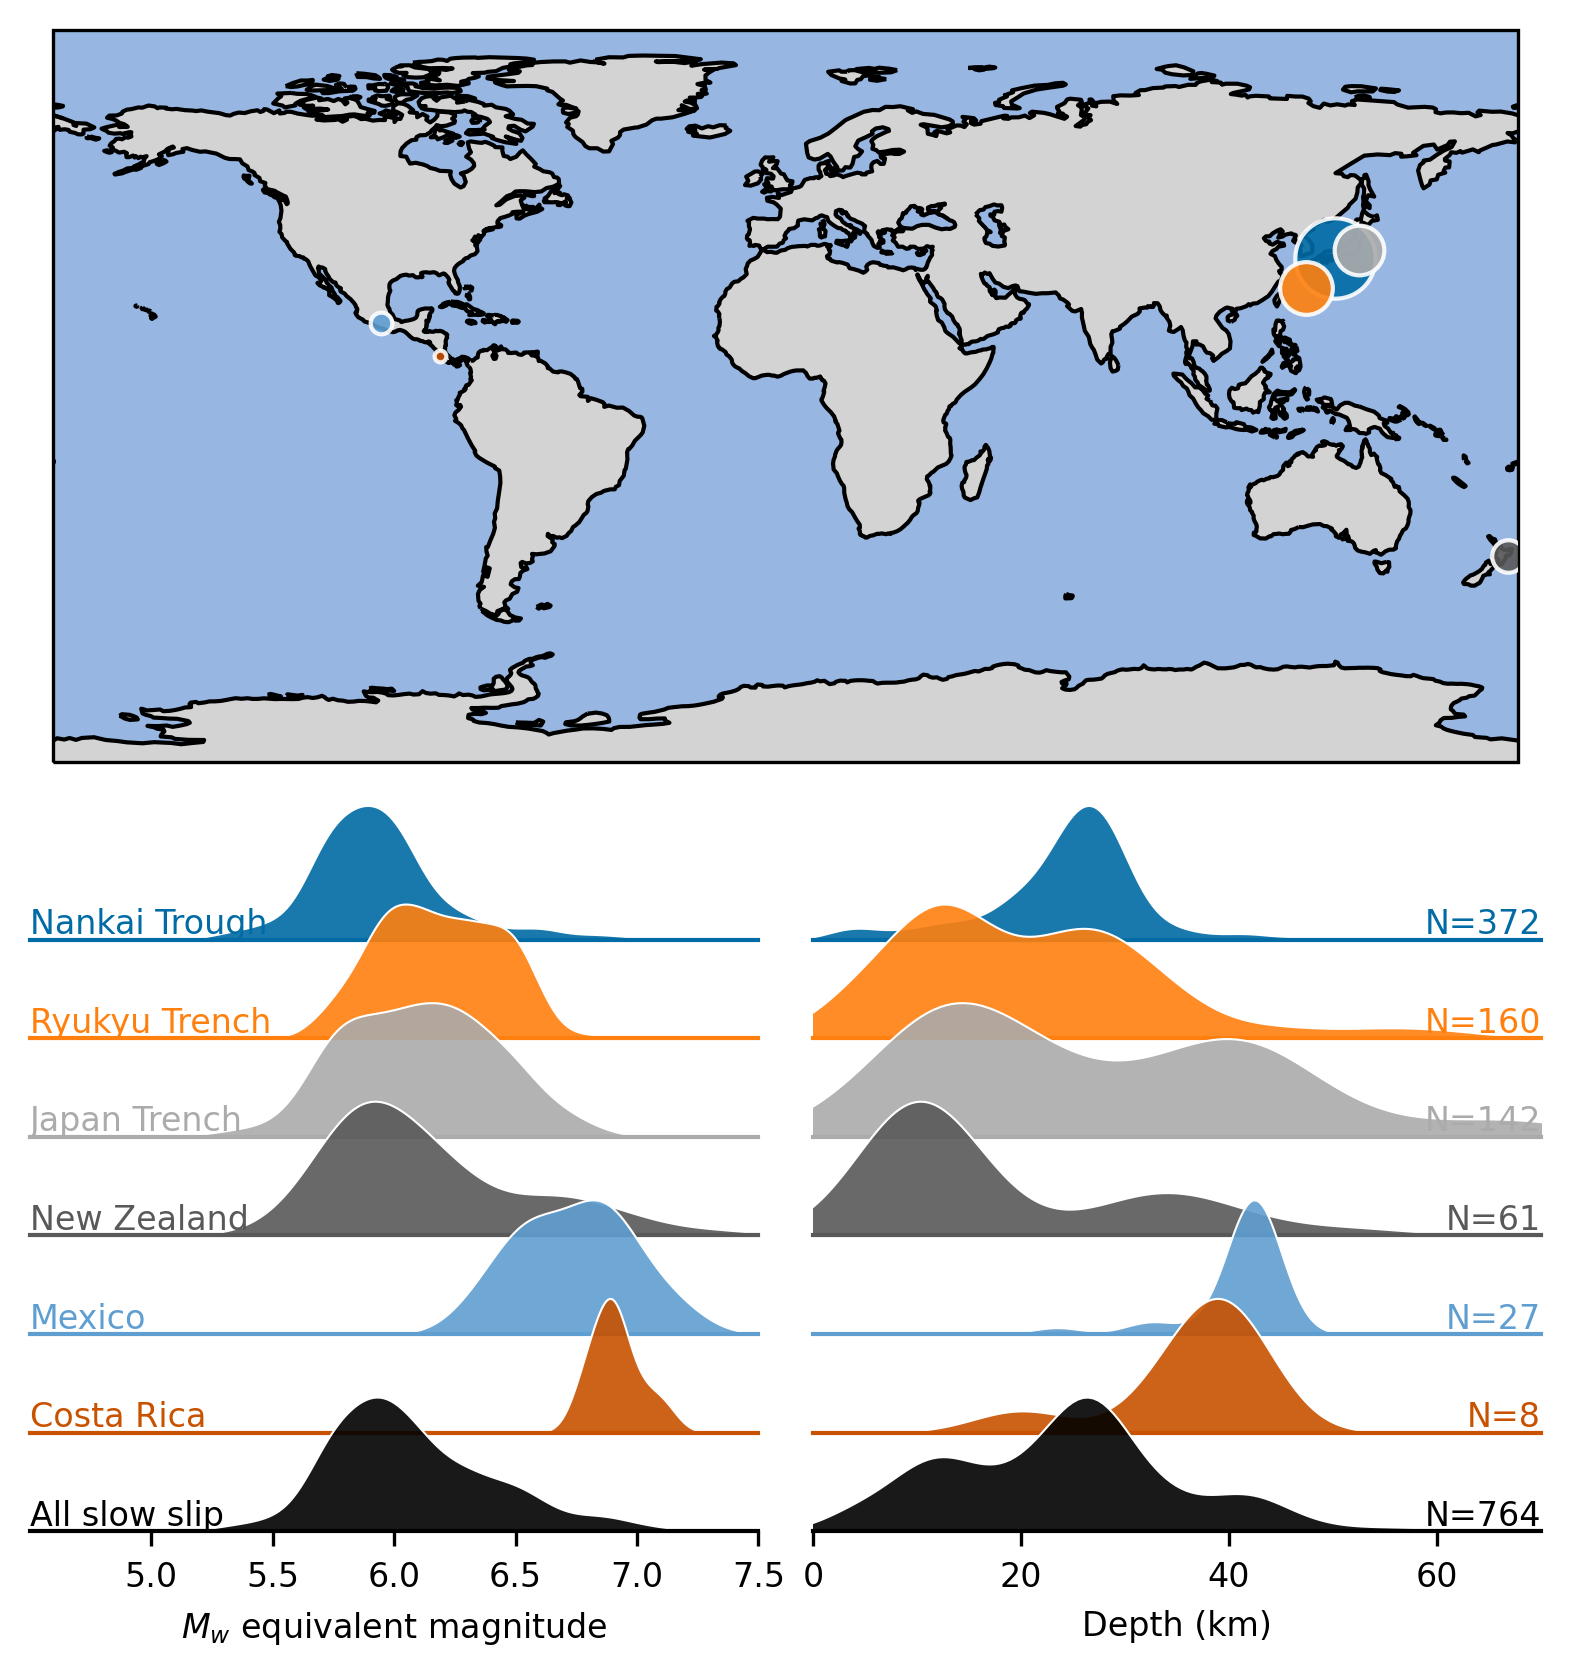

In [12]:
fig = plt.figure(figsize=(6.5,6.5))

gs0 = mpl.gridspec.GridSpec(2, 1,  hspace=0.05)

# Map:
ax0 = fig.add_subplot(gs0[0], projection=ccrs.PlateCarree())
extent = [-180,180,-90,90]
ax0.set_extent(extent,crs=ccrs.PlateCarree(),)
ax0.add_feature(cfeature.LAND, color="lightgray")
ax0.add_feature(cfeature.OCEAN)
ax0.add_feature(cfeature.COASTLINE)

for i_slowslip in slowslip:
    ax0.scatter(
        np.mean(i_slowslip.catalog.lon),
        np.mean(i_slowslip.catalog.lat),
        s=len(i_slowslip),
        edgecolors='w',
        label=f"N={len(i_slowslip)}, {i_slowslip.name}",
        zorder=10,
        alpha=0.9
    )

# ax0.legend(loc='lower left')

# Two colomns of ridgelin plots:
gs01 = mpl.gridspec.GridSpecFromSubplotSpec(len(slowslip)+1, 2, subplot_spec=gs0[1], hspace=-0.3, wspace=0.075)

def clean_ax(ax):
    ax.set(
        yticks=[],
        xticks=[],
        ylabel='',
        xlabel='',
        xticklabels=[],
    )
    rect = ax.patch
    rect.set_alpha(0)
    spines = ["top","right","left","bottom"]
    for s in spines:
        ax.spines[s].set_visible(False)

mag_AX = []
depth_AX = []
for i,ss in enumerate(slowslip+[all_slowslip]):
    shared_kwargs = dict(
        data=ss.catalog,
        color=f"C{i}" if i<len(slowslip) else 'k',
        linewidth=0.5,
        edgecolor='w',
        alpha=0.9,
        clip_on=True,
        fill=True,
    )

    mag_AX.append(fig.add_subplot(gs01[i, 0]))
    ax = mag_AX[-1]
    
    sns.kdeplot(
        x='mag',
        **shared_kwargs,
        ax=ax,
    )
    ax.axhline(0, color=f"C{i}" if i<len(slowslip) else 'k',lw=1, clip_on=False)

    ax.set_xlim(4.5,7.5)

    
    depth_AX.append(fig.add_subplot(gs01[i, 1]))
    ax = depth_AX[-1]
    
    sns.kdeplot(
        x='depth',
        ax=ax,
        **shared_kwargs,
    )
    ax.axhline(0, color=f"C{i}" if i<len(slowslip) else 'k',lw=1, clip_on=False)
    ax.set_xlim(0,70)
    
    [clean_ax(ax) for ax in [mag_AX[-1], depth_AX[-1]]]    


for i in range(len(slowslip)+1):
    ax = mag_AX[i]
    ax.text(
        0, 
        0.04, 
        slowslip[i].region if i<len(slowslip) else 'All slow slip', 
        color=ax.lines[-1].get_color() if i<len(slowslip) else 'k',
        transform=ax.transAxes, 
        ha='left'
    )
    
    ax = depth_AX[i]
    ax.text(        
        1, 
        0.04,
        f"N={len(slowslip[i])}" if i<len(slowslip) else f"N={len(all_slowslip)}",
        color=ax.lines[-1].get_color() if i<len(slowslip) else 'k',
        transform=ax.transAxes, 
        ha='right'
    )
    
ax = depth_AX[-1]
xticks = [0,20,40,60]
ax.set(xticks=xticks, xticklabels=xticks, xlabel='Depth (km)')

ax = mag_AX[-1]
xticks = np.arange(5,8,0.5)
ax.set(xticks=xticks, xticklabels=xticks, xlabel='$M_w$ equivalent magnitude');

In [13]:
catalog1 = all_slowslip
catalog2 = local_earthquakes
R = 50
T = 10
# time window
is_in_time_window = np.abs(
    catalog1.catalog.time.values.reshape(-1,1) - catalog2.catalog.time.values.reshape(1,-1)
) < np.timedelta64(T,'D')/2# dimensions: (len(catalog1), len(catalog2))

# space window
is_in_space_window = np.zeros_like(is_in_time_window)
neighboring_indices = catalog1.get_neighboring_indices(catalog2, R)
for i in range(len(catalog1)):
    if len(neighboring_indices[i]) > 0:
        is_in_space_window[i, neighboring_indices[i]] = True

# combine time and space windows
is_in_window = is_in_time_window & is_in_space_window


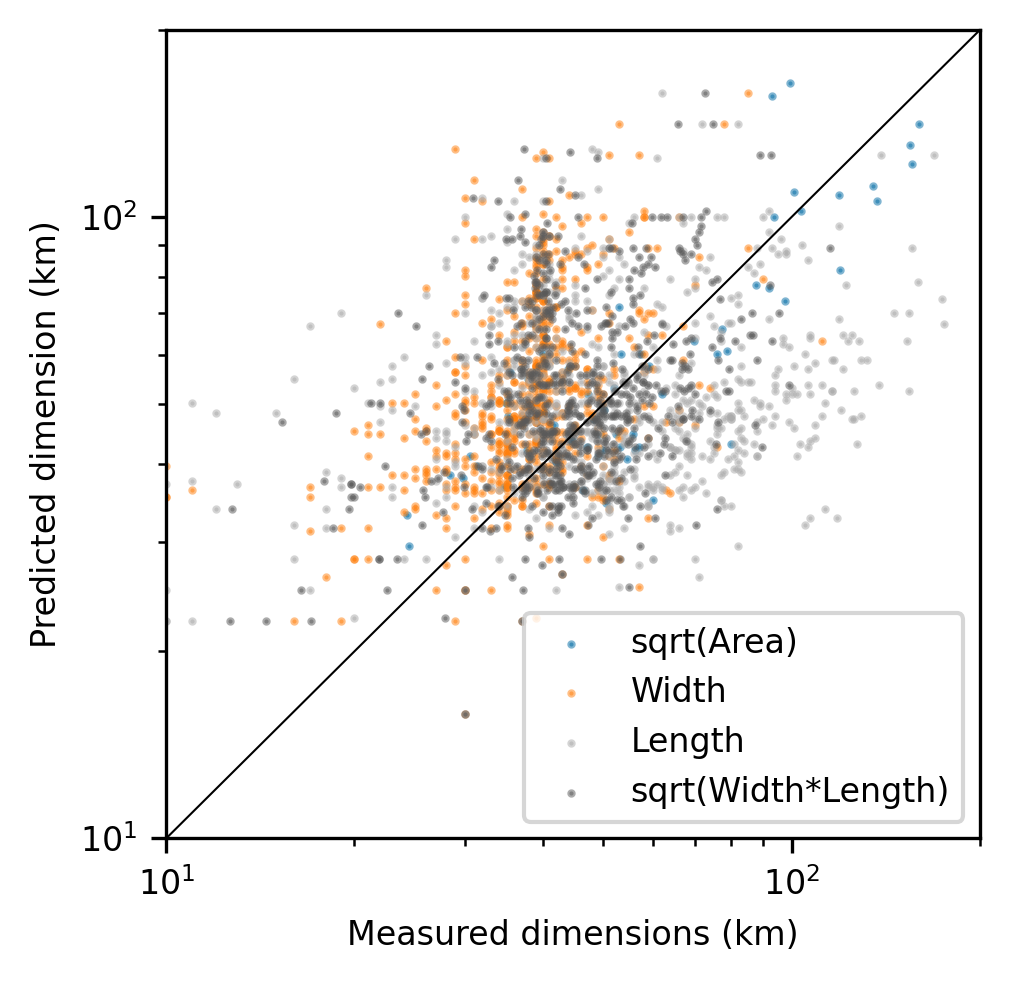

In [14]:
sse_dimension = Scaling.magnitude_to_size(all_slowslip.catalog.mag, all_slowslip._stress_drop, "km")

fig, ax = plt.subplots(figsize=(3.5,3.5))
ax.scatter(all_slowslip.catalog.Area**0.5, sse_dimension, s=1, alpha=0.5, label='sqrt(Area)')
ax.scatter(all_slowslip.catalog.width, sse_dimension, s=1, alpha=0.5, label='Width')
ax.scatter(all_slowslip.catalog.length, sse_dimension, s=1, alpha=0.5, label='Length')
ax.scatter((all_slowslip.catalog.width*all_slowslip.catalog.length)**0.5, sse_dimension, s=1, alpha=0.5, label='sqrt(Width*Length)')
ax.plot([10,200],[10,200], color='k', lw=0.5)
ax.set(xscale='log', yscale='log', xlabel='Measured dimensions (km)', ylabel='Predicted dimension (km)',
       xlim = [10,200], ylim = [10,200])
ax.legend(loc='lower right', fontsize=8)

## Global stacking

### Time stacks

In [15]:
def center_sequences(
    slowslipevents: Catalog = all_slowslip,
    earthquakes: Catalog = local_earthquakes,
    time_window: Union[float,np.ndarray] = 100,
    space_window: float = 100,
    lag = 0,
    slab_model=all_slabs,
    concatenate_output: bool = True,
    return_indices: bool = False,
):
        
    return src.center_sequences(
        slowslipevents,
        earthquakes,
        time_window,
        space_window,
        lag,
        slab_model,
        concatenate_output,
        return_indices,
    )

In [16]:
def get_p_relative_to_back(
    slowslipevents = all_slowslip,
    earthquakes = local_earthquakes,
    event_duration = 30,
    buffer_dutation = 30,
    background_duration = 5*365,
    radius_km = 100, 
    return_time_lags = True,
    number_samples = 1000,
):

    T_event = event_duration
    buffer = buffer_dutation
    T_pre = background_duration 
    R = radius_km

    pre_time_lags, buffer_time_lags, co_time_lags = [
        center_sequences(slowslipevents, earthquakes, time_window=T,space_window=R,lag=L, concatenate_output=False)[0]
        for T, L in zip(
            [T_pre, buffer, T_event],
            [-T_pre/2 - T_event/2 - buffer, -T_event/2-buffer/2, 0],
        )
    ]

    p_values = []

    for pre, co in zip(pre_time_lags, co_time_lags):
        N_baseline = []
        
        for _ in range(number_samples):
            random_window_start_time = np.random.uniform(
                -T_pre - T_event/2 - buffer,
                -T_event/2 - buffer - T_event # -T_event because we want to avoid the event itself
            )
            
            # count number times in pre that are in the range [random_window_start_time, random_window_start_time + T_event]
            N_baseline.append(
                np.sum(
                    (pre > random_window_start_time) & (pre < random_window_start_time + T_event)
                )
            )
        eps = 0 # perturb the baseline by a small amount such that window is the same number of events are divied up equally
        p_values.append(
            np.mean(
                len(co) <= np.array(N_baseline)  + np.random.uniform(-eps,eps,len(N_baseline))
            )
        )

    p_values = np.array(p_values)
    
    if return_time_lags:
        return p_values, pre_time_lags, buffer_time_lags, co_time_lags
    else:
        return p_values

## Temporal stacking

In [17]:
time_window = 360 # days

global_relative_times, global_relative_distances, global_weights = center_sequences(time_window=time_window)

regional_relative_times = []
regional_relative_distances = []
regional_weights = []
regionalized_weights = []
regional_window_indices = []

for region in slowslip:
    dt, dx, w, I = center_sequences(region,time_window=time_window, return_indices=True)
    regional_relative_times.append(dt)
    regional_relative_distances.append(dx)
    regional_weights.append(w)
    regionalized_weights.append(w/len(w))
    regional_window_indices.append(I)
    
combined_regional_relative_times = np.concatenate(regional_relative_times)
regionalized_weights = np.concatenate(regionalized_weights)
    

In [18]:
regional_jackknife = []
bw = 0.05
number_of_times = 1000
time_array = np.linspace(-time_window/2, time_window/2, number_of_times)
for i in range(len(slowslip)):
    i_slowslip = [sse for n,sse in enumerate(slowslip) if n != i] # all but the ith slow slip event
    dt, dx, w = center_sequences(sum(i_slowslip[1:],i_slowslip[0]),time_window=time_window)
    regional_jackknife.append(
        gaussian_kde(dt, bw_method=bw, weights=w)(time_array)
    )

In [19]:
p = []
for i_slowslip in slowslip:
    p_values = get_p_relative_to_back(i_slowslip, return_time_lags=False)
    p.append((np.log10(np.mean(p_values<0.05)/0.05)/1.5 + 0.5))

In [20]:
def add_gbar(ax,v, cmap='RdBu_r'):
    cax = ax.inset_axes([0.01, 0.7, 0.2, 0.2])
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, cax=cax, orientation='horizontal', fraction=1, aspect=20)
    cb.ax. plot(v,0.5, 'k', marker='o',markersize=2.5)
    cb.ax.set(
        xticks=[],
    )
    return cb

Text(0, 0.5, 'Earthquakes')

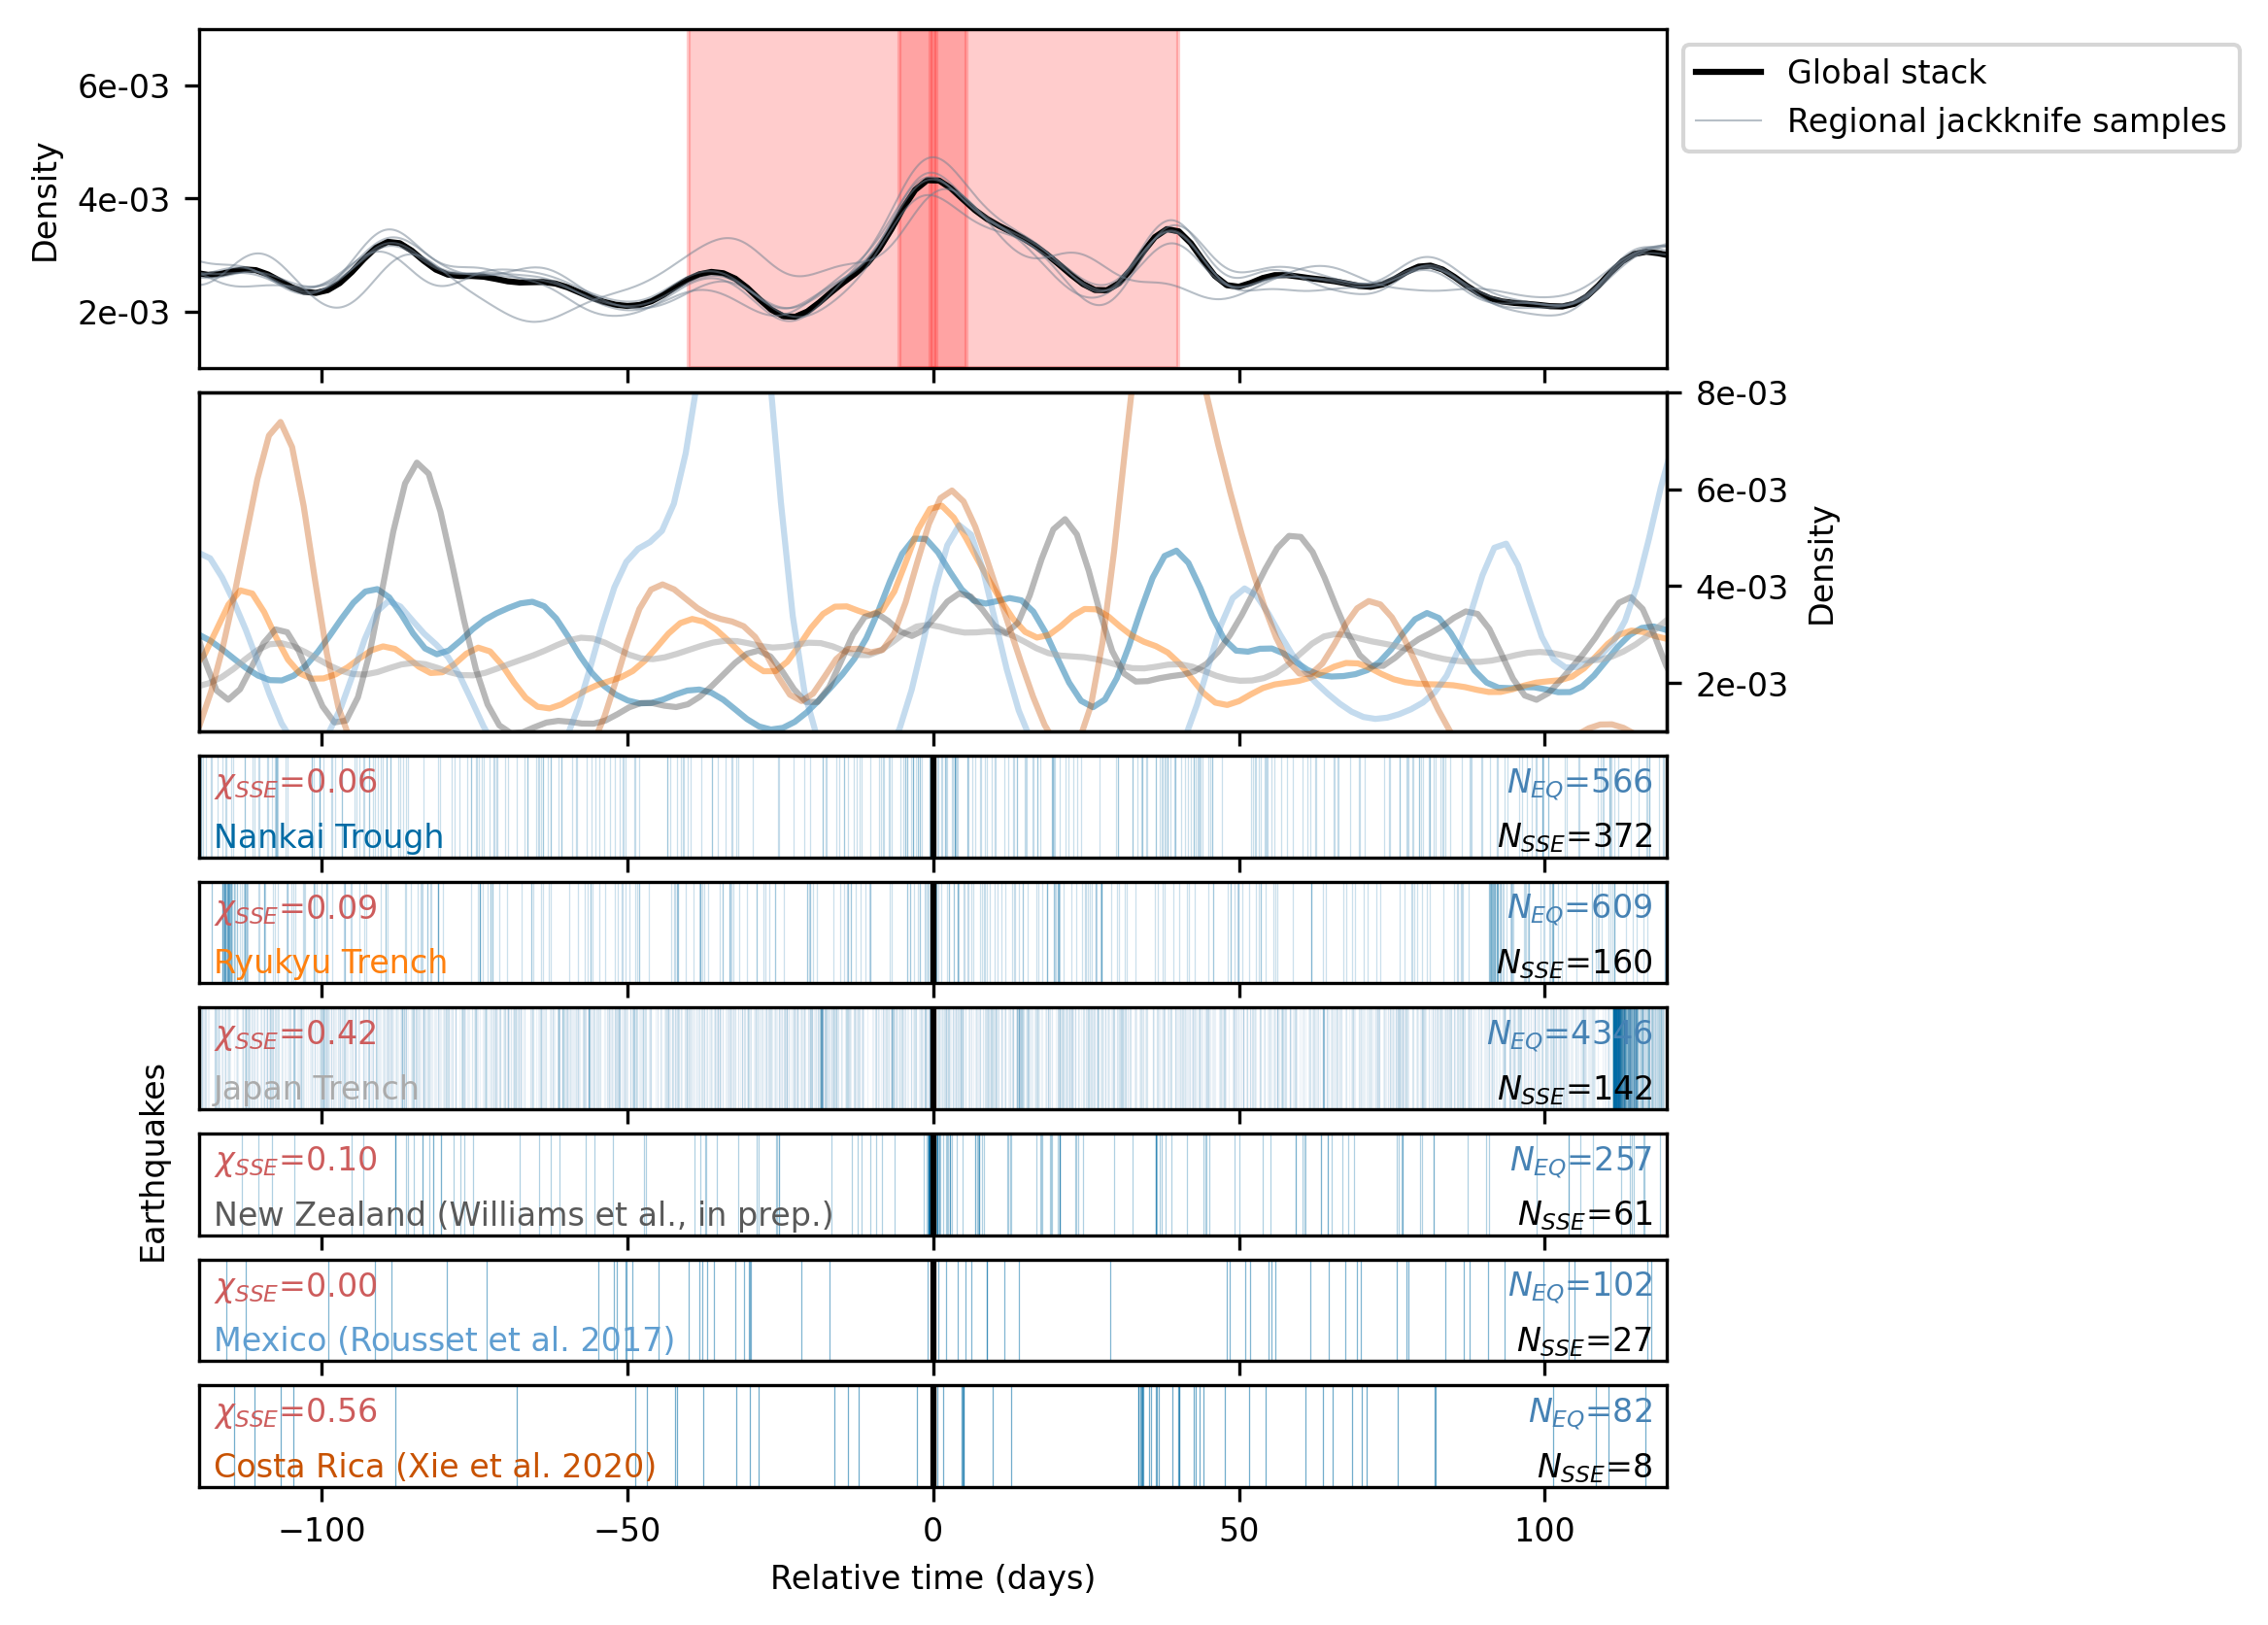

In [21]:
fig, AX = plt.subplots(len(slowslip)+2, 1, figsize=(6.5,6.5), sharex=True, gridspec_kw=dict(hspace=0.15, height_ratios=2*[1]+len(slowslip)*[0.3]))
data_std = np.std(global_relative_times)
smoothing_bandwidth = 5
bw = smoothing_bandwidth/data_std


duration = all_slowslip.catalog['duration'].dropna().values/60/60/24
duration = duration[duration>0]
q = np.quantile(duration, [0.05,0.5,0.95])

[
    AX[0].axvspan(-iq/2, iq/2, color='red', alpha=0.2)
    for iq in q
]
sns.kdeplot(
    x=global_relative_times,
    label=f"Global stack", 
    ax=AX[0],
    color='k',
    **dict(bw_method=bw, weights=global_weights)
)
lh = [
    AX[0].plot(time_array, regional_jackknife[i], color='slategray', lw=0.5, alpha=0.5) for i in range(len(slowslip))
]
lh[0][0].set_label('Regional jackknife samples')
AX[0].legend(loc='upper left', bbox_to_anchor=(1,1))
AX[0].set(
    ylim=(0.001,0.007),
)
AX[0].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0e'))

AX[1].set(yticks=[])
axb = AX[1].twinx()
for dt,w in zip(regional_relative_times, regional_weights):
    sns.kdeplot(
        x=dt,
        label=f"KDE bandwidth: {smoothing_bandwidth} days", 
        ax=axb,
        **dict(bw_method=bw, weights=w),
        alpha=1-len(dt)**-0.1,
    )
axb.set(
    ylim=(0.001,0.008),
)
axb.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0e'))

# ax.set_yticklabels(ax.get_yticks()*len(relative_times))

for i, region, dt, ip, i_window_indices, iax in zip(
    range(len(slowslip)), 
    slowslip, 
    regional_relative_times, 
    p, 
    regional_window_indices, 
    AX[2:]
):
    sns.rugplot(dt, ax=iax, label=f'{region.name}', height=1, lw=0.3, alpha=min(1,5/np.sqrt(len(dt)))) 
    iax.set(
        yticks=[],
    )
    
    # calculate the seiscmic coupling?
    Mo_sse = (10**(3/2*region.catalog['mag']+9.1)).sum()
    
    unique_indices = np.unique(np.concatenate(i_window_indices))
    Mo_eq = (10**(3/2*local_earthquakes.catalog['mag'].values[unique_indices]+9.1)).sum()
    
    coupling = Mo_eq/(Mo_sse+Mo_eq)
    
    iax.text(0.01,0.9,'$\chi_{SSE}$='+ f'{coupling:.2f}',transform=iax.transAxes, ha='left', va='top', color='indianred')
    iax.text(0.01,0.1,region.name,transform=iax.transAxes,color=f'C{i}')
    iax.text(0.99,0.1,"$N_{SSE}$" + f"={len(region)}",transform=iax.transAxes, ha='right')
    iax.text(0.99,0.9,"$N_{EQ}$" + f"={len(dt)}",transform=iax.transAxes, ha='right', va='top', color='steelblue')
    iax.axvline(0, color='k')


AX[-1].set(
    xlabel='Relative time (days)',
    xlim=[-time_window/3,time_window/3],
)

AX[4].set_ylabel('Earthquakes', ha='right')

## Spatial stacks

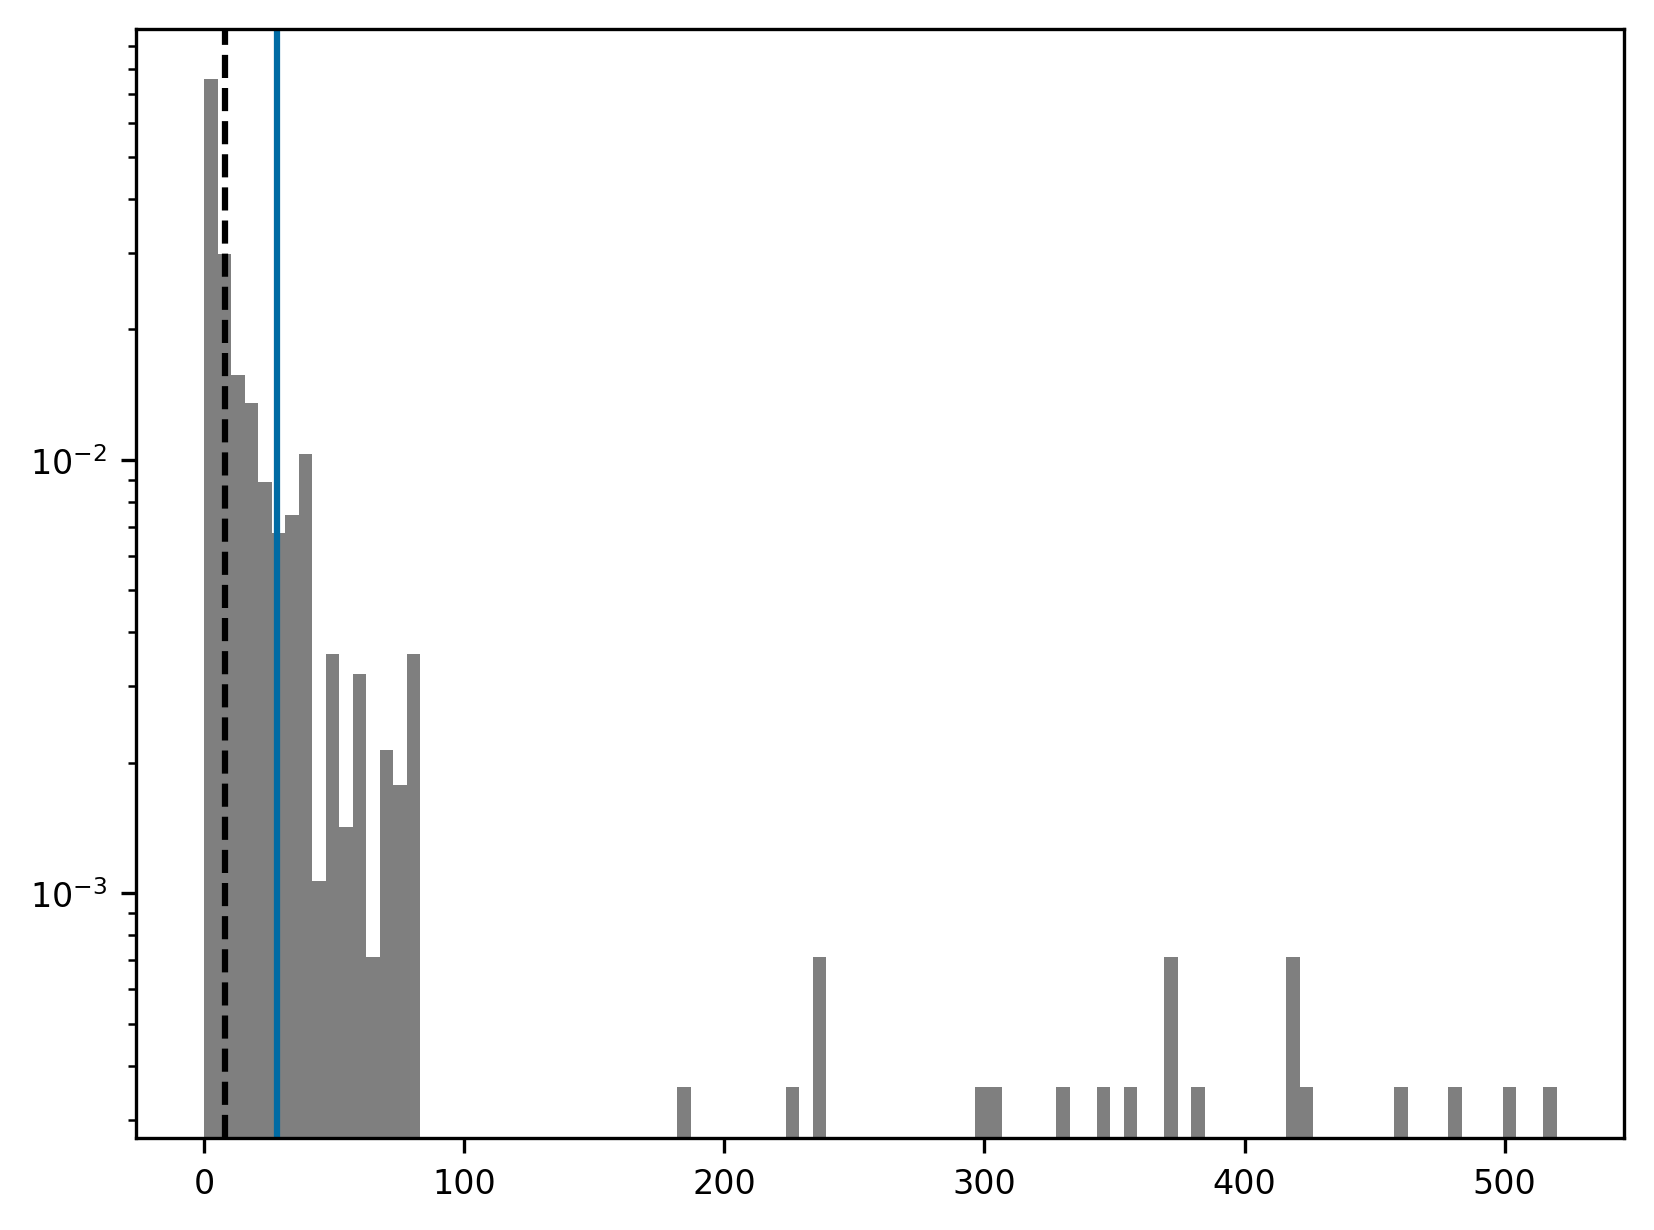

In [22]:
plt.hist(all_slowslip.catalog['duration'].values/60/60/24, log=True, bins=100, color='k', alpha=0.5, density=True, label='All slow slip')
plt.axvline(np.nanmean(all_slowslip.catalog['duration'].values/60/60/24))  
plt.axvline(np.nanmedian(all_slowslip.catalog['duration'].values/60/60/24),c='k',ls='--')

In [23]:
T_pre = 720
buffer = 30
T_event = all_slowslip.catalog['duration'].values/60/60/24 # days
W = 500 # km
_, co_event_stack_combined, co_weights = center_sequences(time_window=T_event,space_window=W,lag=0)
_, pre_event_stack_combined, pre_weights = center_sequences(time_window=T_pre,space_window=W,lag=(-T_pre/2 - T_event/2 - buffer))
_, post_event_stack_combined, post_weights = center_sequences(time_window=T_event,space_window=W,lag=T_event/2)

In [24]:
# Define the bandwidth for smoothing
smoothing_bandwidth = 0.08

# Create the kernel density estimators
dens_pre_kde = gaussian_kde(pre_event_stack_combined.T, bw_method=smoothing_bandwidth, weights=pre_weights)
dens_co_kde = gaussian_kde(co_event_stack_combined.T, bw_method=smoothing_bandwidth, weights=co_weights)
dens_post_kde = gaussian_kde(post_event_stack_combined.T, bw_method=smoothing_bandwidth, weights=post_weights)

# Define the range and grid
number_of_source_dimensions = 2
xmin, xmax = -number_of_source_dimensions, number_of_source_dimensions
ymin, ymax = -number_of_source_dimensions, number_of_source_dimensions
grid_size = 100

# Create a grid of points
xx, yy = np.meshgrid(np.linspace(xmin, xmax, grid_size), np.linspace(ymin, ymax, grid_size))
grid_points = np.column_stack((xx.flatten(), yy.flatten()))



# Evaluate the density ratio on the grid
dens_co = dens_co_kde(grid_points.T).reshape(xx.shape)
dens_pre = dens_pre_kde(grid_points.T).reshape(xx.shape)
dens_post = dens_post_kde(grid_points.T).reshape(xx.shape)
density_ratio = dens_post/dens_pre


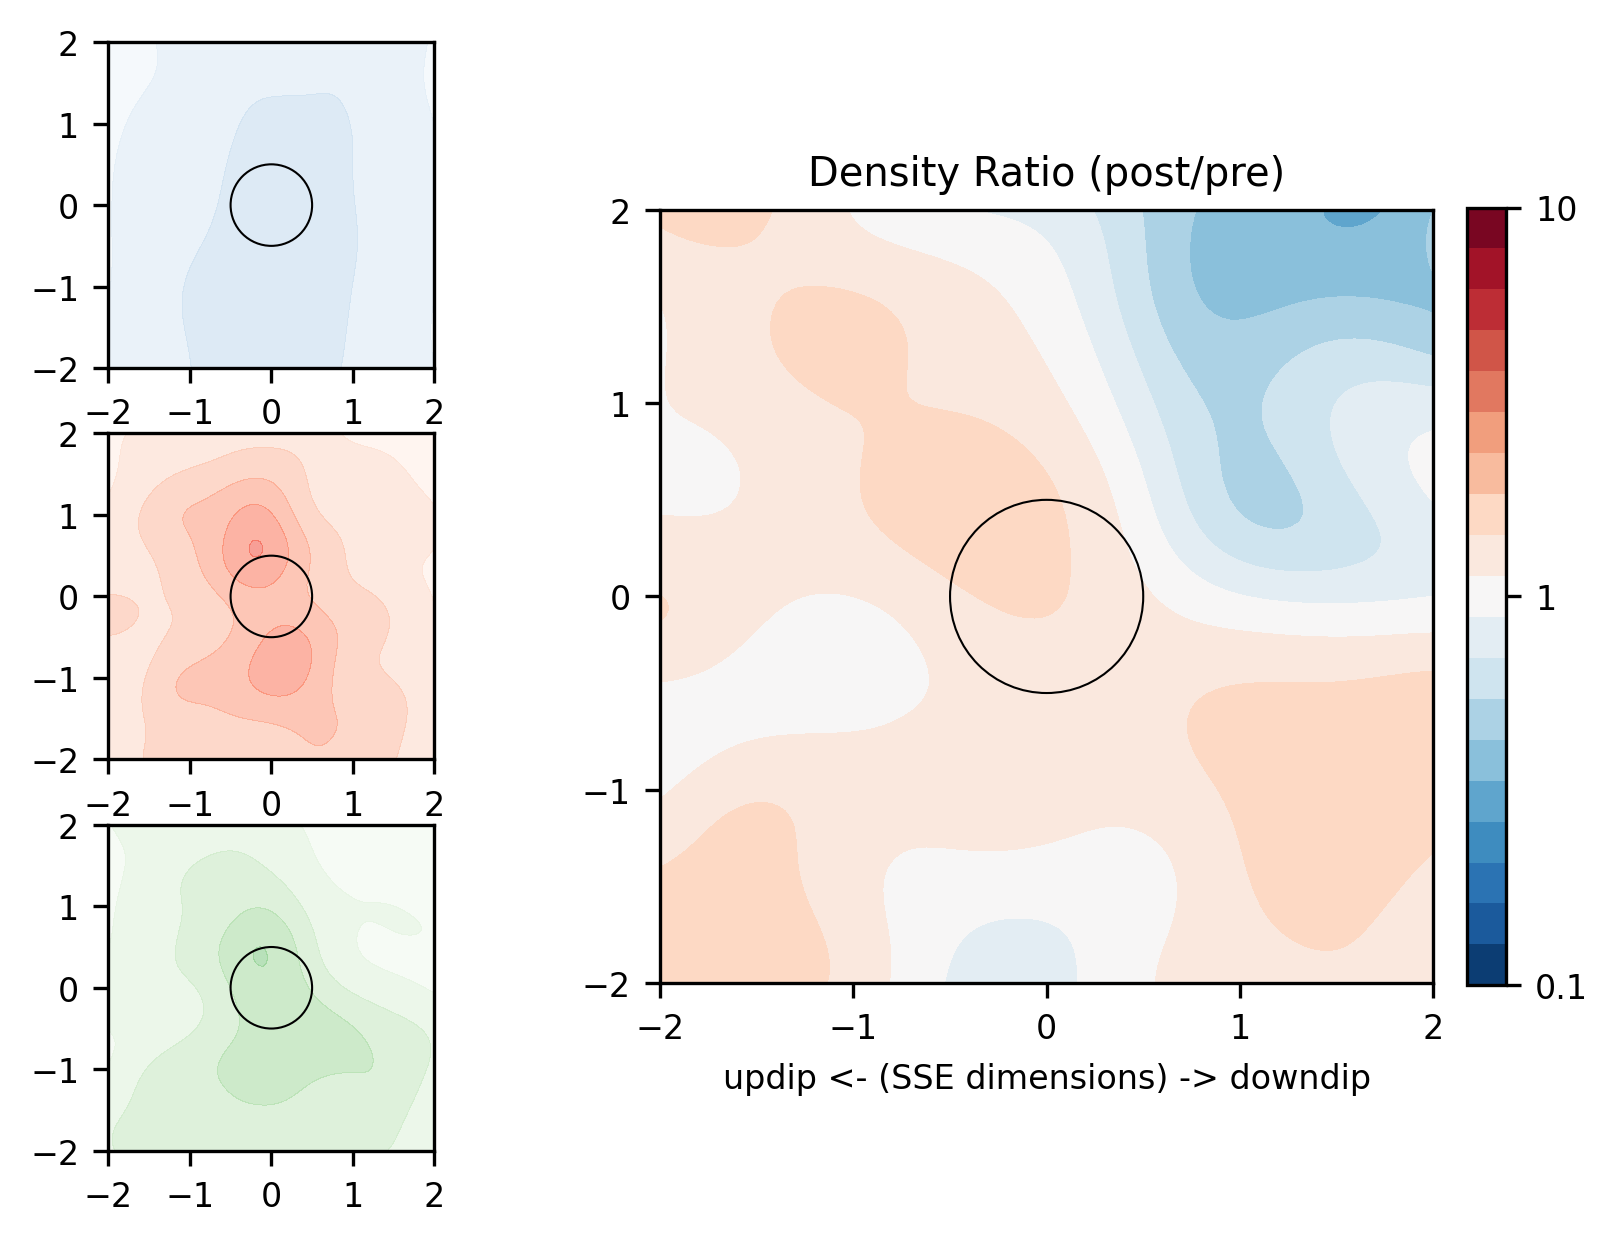

In [25]:

# Create a 2x2 grid with ratios [1, 1, 2] for the row heights
gs = mpl.gridspec.GridSpec(3, 2, width_ratios=[1.2, 2])

levels = np.linspace(0, 0.05, 10)

# Subplot 1 - Top plot
ax1 = plt.subplot(gs[0, 0])  # First row, first column
ax1.contourf(xx, yy, dens_pre, cmap='Blues',alpha=0.5, levels=levels)

# Subplot 2 - Middle plot
# share the x-axis with ax1
ax2 = plt.subplot(gs[1, 0], sharex=ax1)  # Second row, first column
ax2.contourf(xx, yy, dens_co, cmap='Reds',alpha=0.5, levels=levels)

# Subplot 3 - Bottom plot
ax3 = plt.subplot(gs[2, 0])  # third row, first column
ax3.contourf(xx, yy, dens_post, cmap='Greens',alpha=0.5, levels=levels)


# Subplot 3 - Right plot
ax4 = plt.subplot(gs[:, 1],  sharex=ax1)  # All rows, second column
ch = ax4.contourf(xx, yy, np.log10(density_ratio), levels=np.linspace(-1, 1, 20), cmap='RdBu_r')
cax4 = plt.colorbar(ch, ax=ax4, fraction=0.046, pad=0.04)

cax4.set_ticks([-1, 0, 1])
cax4.set_ticklabels(['0.1', '1', '10'])
ax4.set(
    xlabel='updip <- (SSE dimensions) -> downdip',
    title='Density Ratio (post/pre)',
)

for iax in [ax1,ax2,ax3,ax4]:
    iax.add_artist(plt.Circle((0, 0), 0.5, color='k', fill=False, lw=0.5))
    iax.set(
        aspect='equal',
        xticks=[-2,-1,0,1,2],
        yticks=[-2,-1,0,1,2],
    );

## Frequency of anomalies

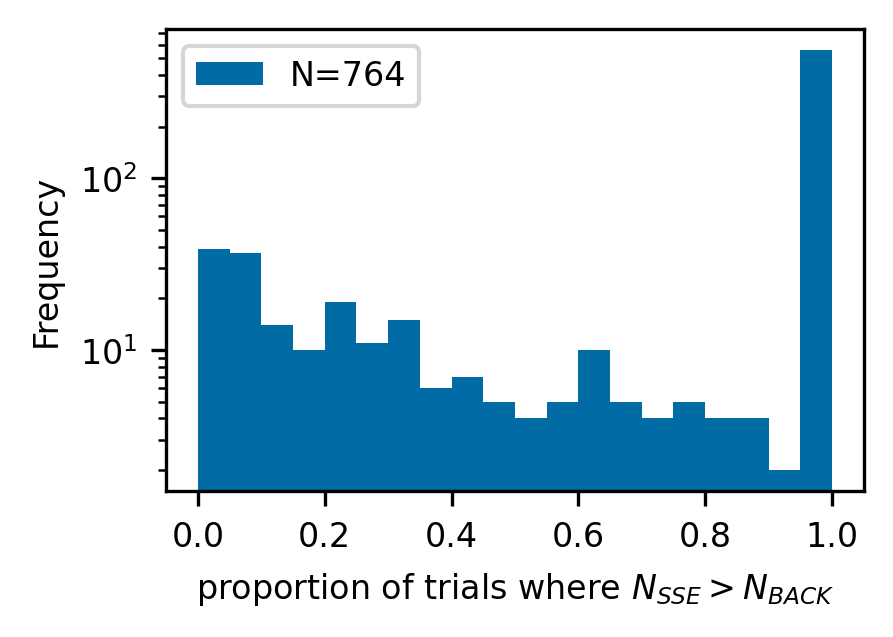

In [26]:
p_values, pre_time_lags, buffer_time_lags, co_time_lags = get_p_relative_to_back()
fig, ax = plt.subplots(1,1,figsize=(3,2))
th = 0.05
ax.hist(p_values, label=f'N={len(p_values)}', bins=20, log=True)
# ax.hist(p_values, label=f'N={len(p_values)}\nfreq. p<{th} = {np.mean(p_values<th):.2f}',bins=np.logspace(-3,0,30),log=True)
# ax.axvline(th, color='r', ls='--',label=f'Freq. of p<{th}= {np.mean(p_values<th):.2f}')
ax.set(xlabel='proportion of trials where $N_{SSE} > N_{BACK}$', ylabel='Frequency')
ax.legend()

In [27]:
## Look at some samples where the p-value is low - which we interpret as a significant increase in the number of events:
I = np.where(p_values < th)[0]

In [28]:
def kstest_sample(array, index):
    return kstest(np.delete(array, index), array[index])
 

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_46670/1467466387.py:24: RuntimeWarning: divide by zero encountered in divide
  moment_rate = 10**(1.5*all_slowslip.catalog.mag.values + 9.1)/all_slowslip.catalog.duration.values


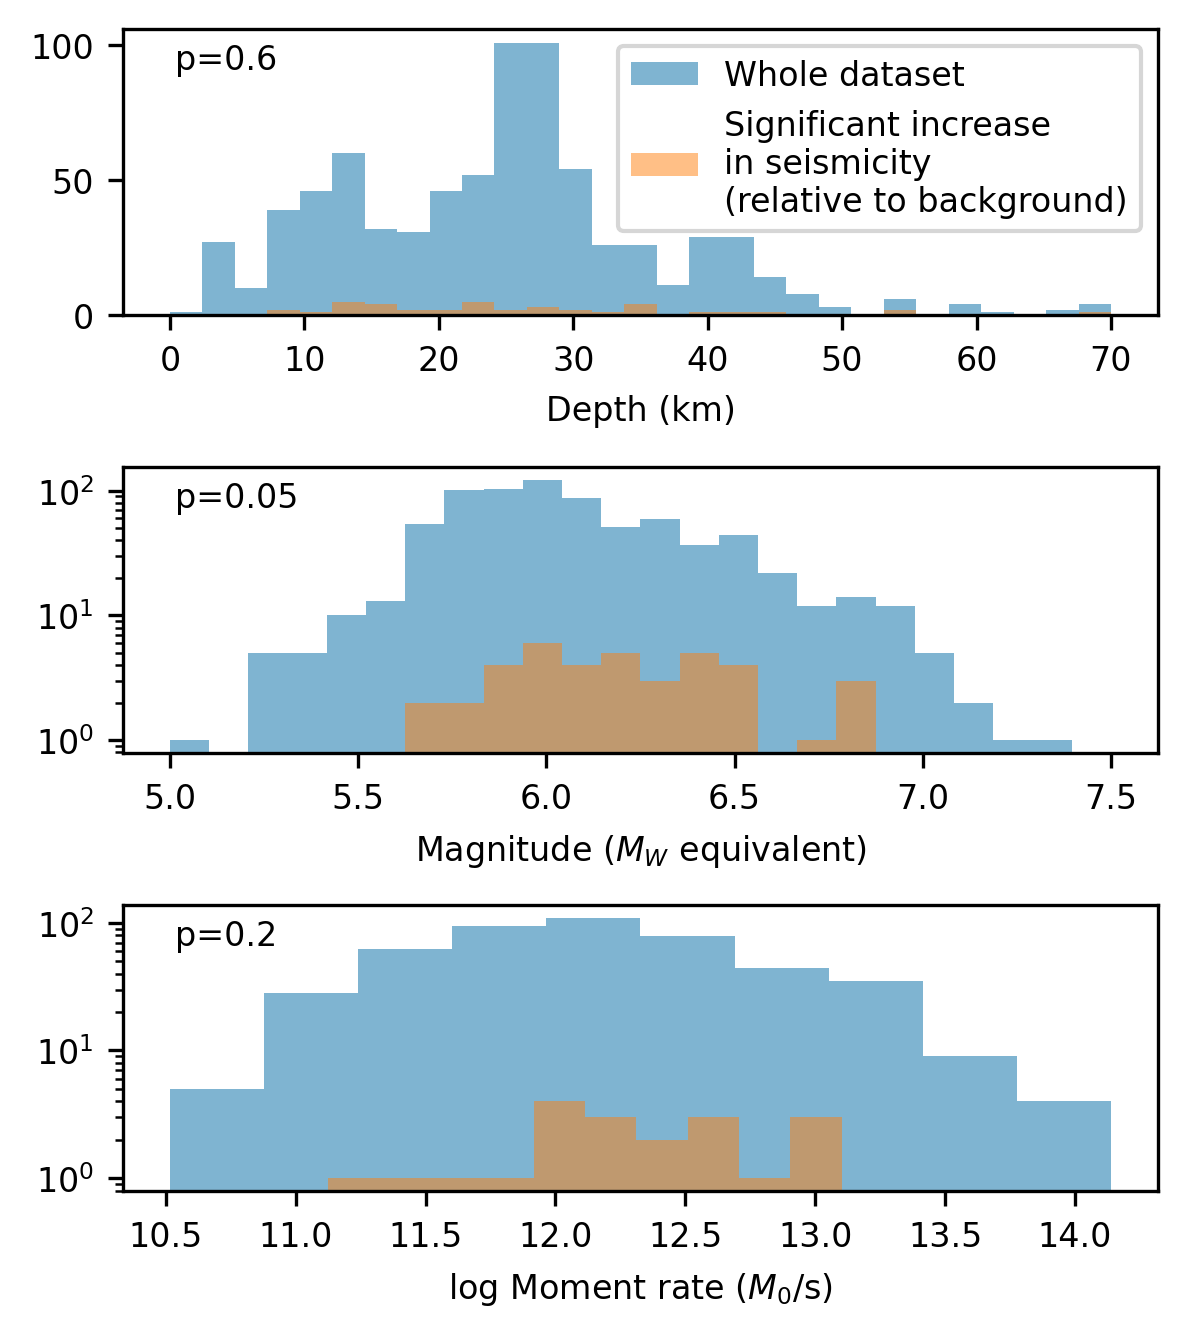

In [29]:
fig, AX = plt.subplots(3,1,figsize=(4,4.5))
ax = AX[0]
bins = np.linspace(0,70,30)
ax.hist(all_slowslip.catalog.depth.values, bins=bins, alpha=0.5, label='Whole dataset')
ax.hist(all_slowslip.catalog.depth.values[I], bins=bins, alpha=0.5, label='Significant increase\nin seismicity \n(relative to background)')
# sns.rugplot(all_slowslip.catalog.depth.values[I], color='r', height=0.25, lw=0.5, ax=ax, label='Significant increase\nin seismicity \n(relative to background)')
ax.set(
    xlabel='Depth (km)',
)

ax.legend()

ax = AX[1]
bins = np.linspace(5,7.5,25)
ax.hist(all_slowslip.catalog.mag.values, bins=bins, alpha=0.5, label='Whole dataset')
ax.hist(all_slowslip.catalog.mag.values[I], bins=bins, alpha=0.5, label='Significant increase\nin seismicity \n(relative to background)')
# sns.rugplot(all_slowslip.catalog.mag.values[I], color='r', height=0.25, lw=0.5, ax=ax,)
ax.set(
    xlabel='Magnitude ($M_W$ equivalent)',
    yscale='log',
)
ax = AX[2]

moment_rate = 10**(1.5*all_slowslip.catalog.mag.values + 9.1)/all_slowslip.catalog.duration.values
I_nan = (~np.isnan(moment_rate)) & (~np.isinf(moment_rate))
ax.hist(np.log10(moment_rate[I_nan]), alpha=0.5, label='Whole dataset')
ax.hist(np.log10(moment_rate[I][I_nan[I]]), alpha=0.5, label='prod')
ax.set_yscale('log')
ax.set_xlabel('log Moment rate ($M_0$/s)')


[
    iax.text(0.05,0.95, f'p={kstest_sample(iarray,I)[1]:0.1}', transform=iax.transAxes, va='top', ha='left') 
    for iax, iarray in zip(AX, [all_slowslip.catalog.depth.values, all_slowslip.catalog.mag.values, moment_rate])
]

plt.tight_layout()

### All places that have slow slip events seem to have some that are abnorally productive

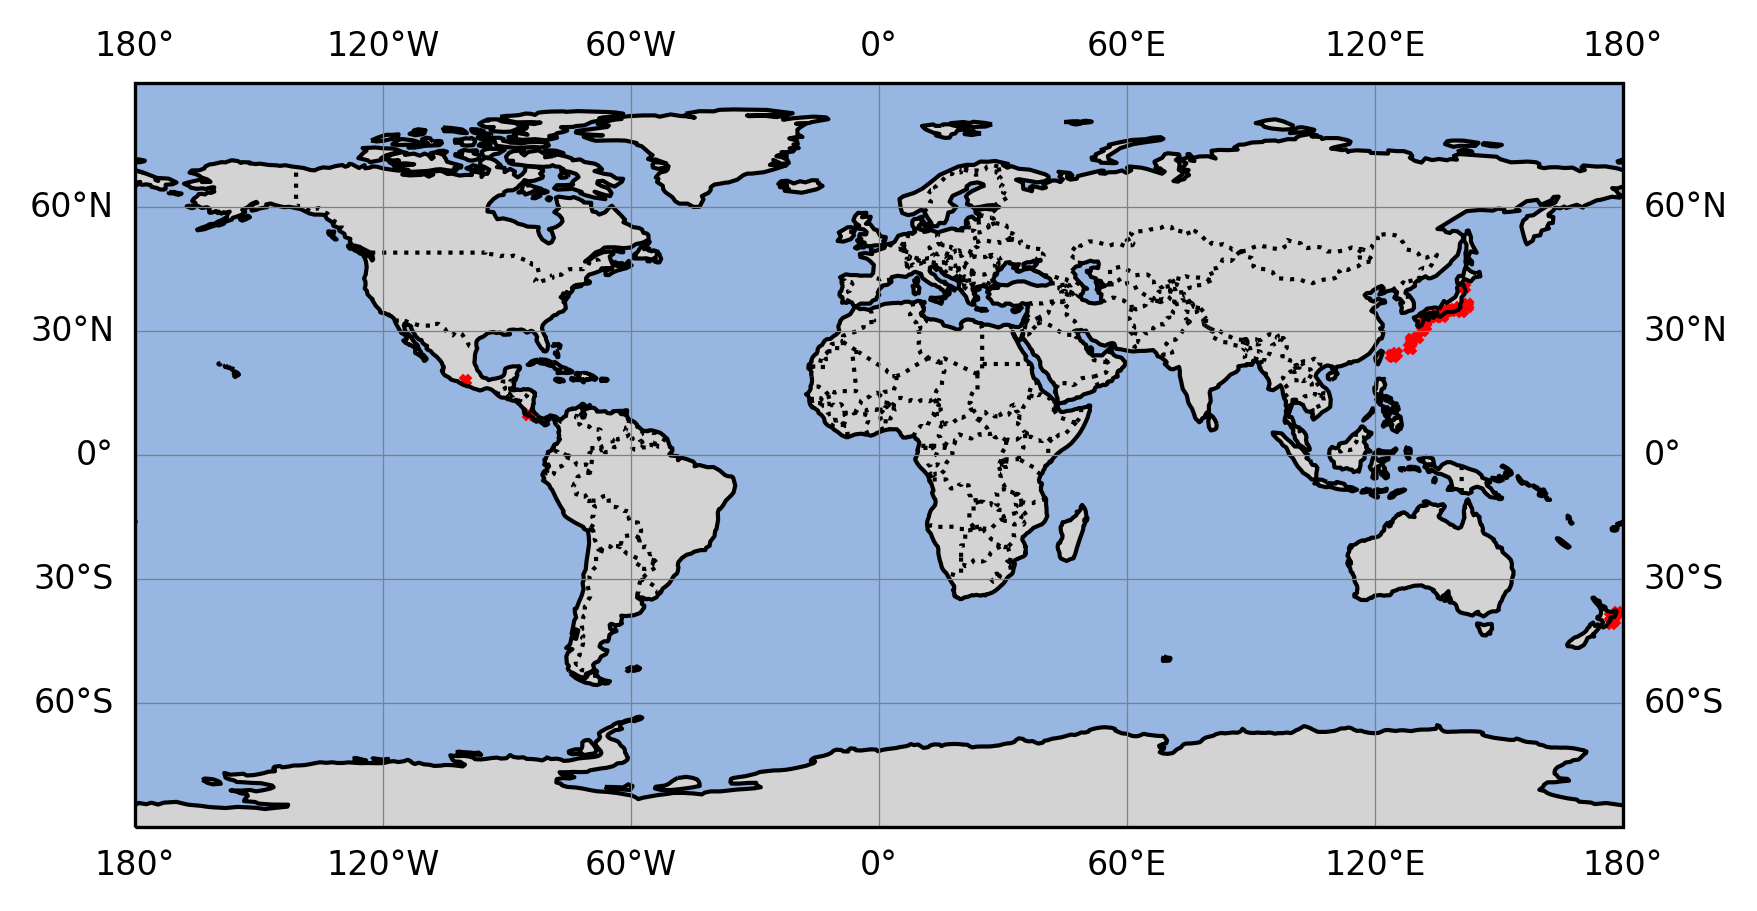

In [30]:
_, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
usemap_proj = ccrs.PlateCarree()
# set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
extent = [-180,180,-90,90]

ax.set_extent(
    extent,
    crs=ccrs.PlateCarree(),
)

ax.add_feature(cfeature.LAND, color="lightgray")
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# plot grid lines
ax.gridlines(draw_labels=True, crs=usemap_proj, color="gray", linewidth=0.3)


ax.scatter(
    all_slowslip.catalog.lon.values[I],
    all_slowslip.catalog.lat.values[I],
    marker='x',
    s=5,
    c='r',
)

A somewhat paradoxical results is that there are on average more earthquakes in the background period than during slow slip events. It is paradoxical because the periods with slow slip are nonetheless abnormal in having more seismicity than a random window in the preceding period. I beleive the only way to reconcile these two results is to suggest that, in general, seismicity prior to slow slip events tends to be quite clustered such that most window end up less productive the period with slow slip events with primarily is accopanied by a more reliable subtle increase in the background rate of seismicity. This might also indicate that in general the seismicity rate, accross then entire dataset is decreasing with time. This is inference is testable by looking at the seismicity rate in the period following the slow slip events.

/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/matplotlib/patches.py:1145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


AttributeError: 'bool' object has no attribute 'any'

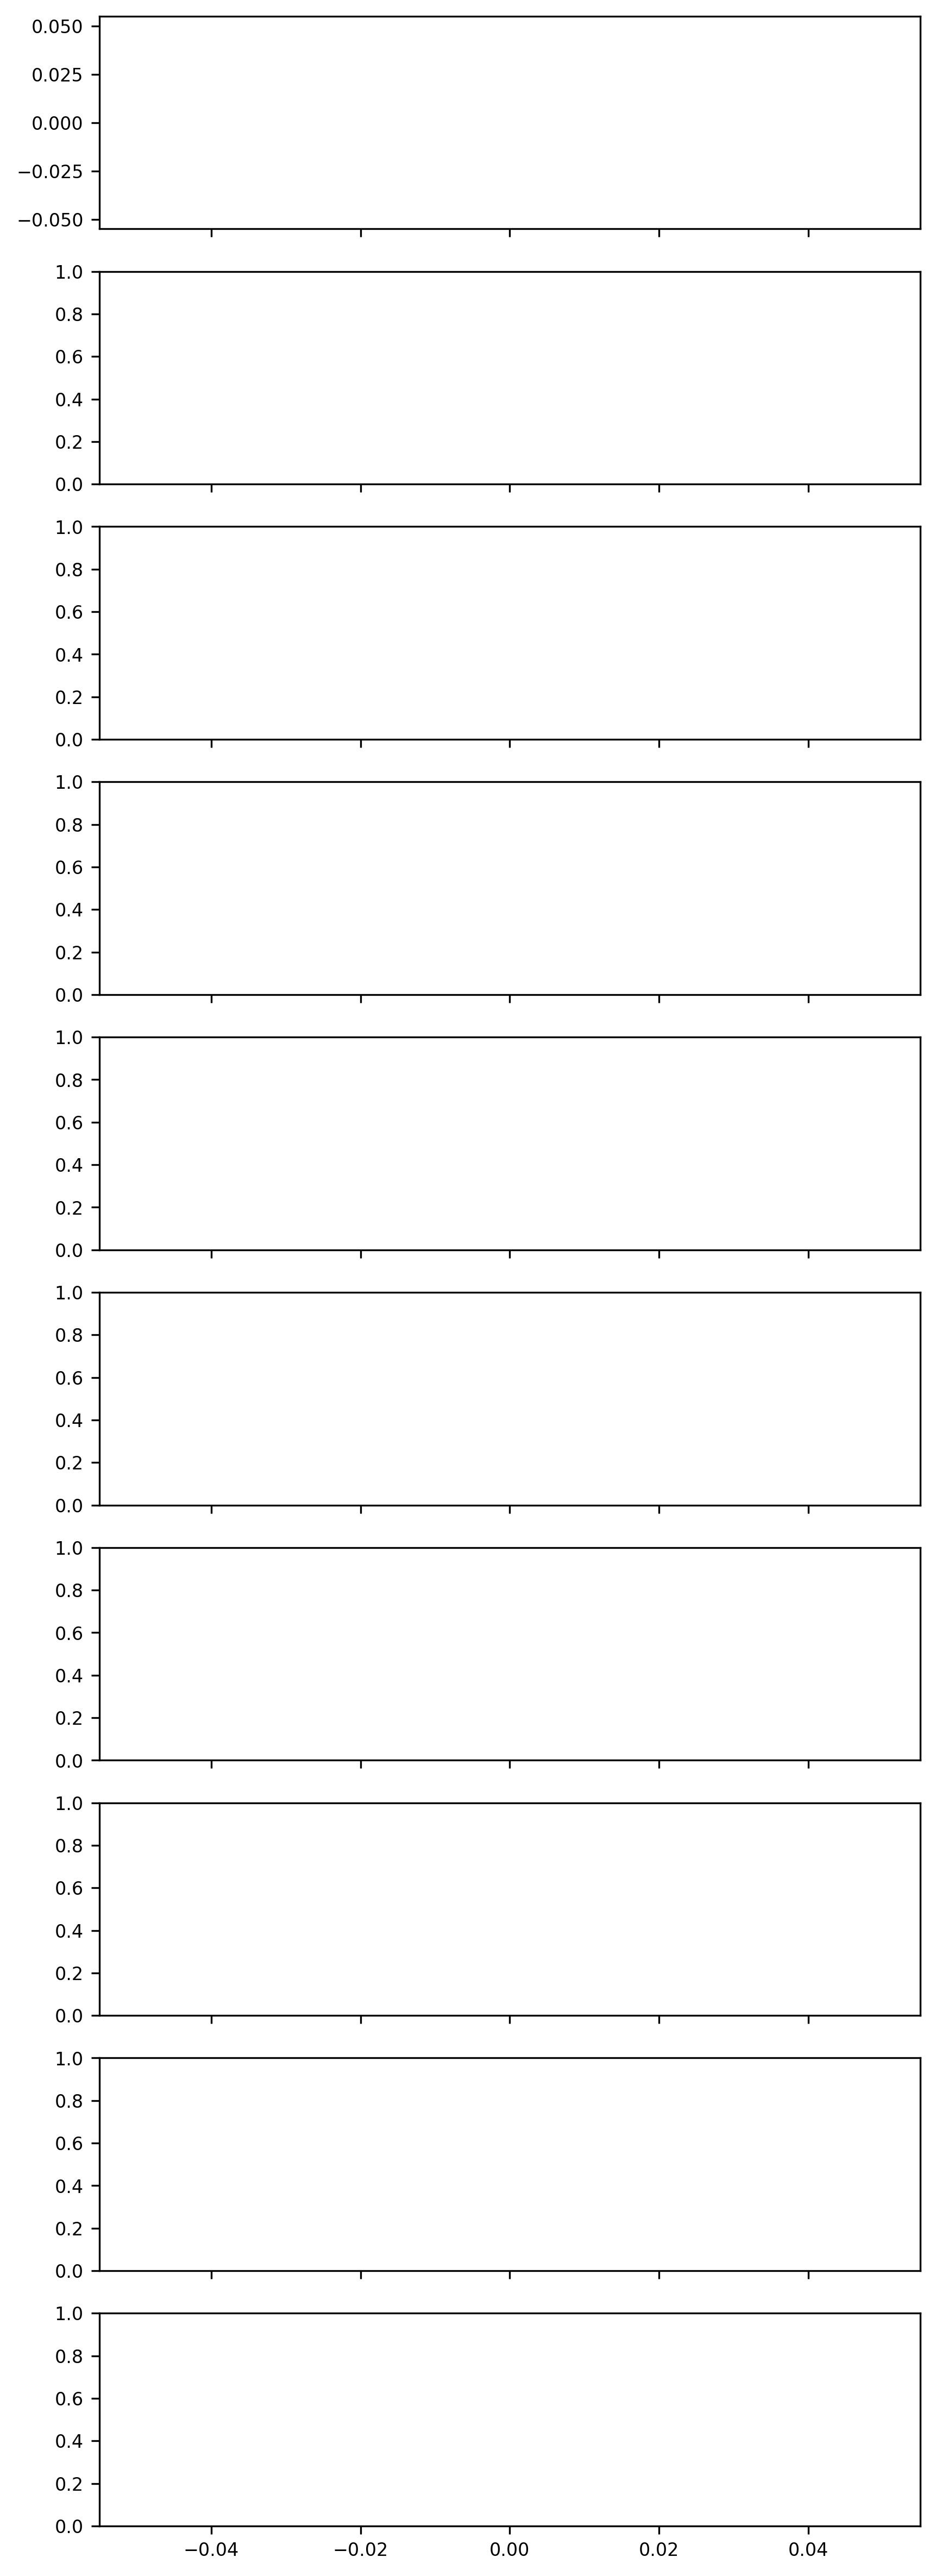

In [31]:
I = np.where(p_values==1)[0]
N = min(len(I),10)
t0 = -500
fig, ax = plt.subplots(N,1, figsize=(6.5,20), sharex=True)
for iax,i in zip(ax,I):
    shared_kwargs = dict(height=1, alpha=0.5, ax=iax)
    [sns.rugplot(dt[i],color=c, **shared_kwargs) for dt,c in zip([pre_time_lags, buffer_time_lags, co_time_lags], ['b','k','r'])]
    
    [
        iax.axvspan(x1,x2, color=c, alpha=0.2, lw=0) 
        for x1,x2,c in zip(
            [-T_pre-buffer-T_event/2, -T_event/2-buffer, -T_event/2],
            [-T_event/2-buffer, -T_event/2, T_event/2],
            ['b','k','r'],
        )
    ]
    iax.set(yticklabels=[], xlim=[t0, T_event/2], ylabel='', yticks=[])
    
[
    ax[0].text(x,1.1, va='bottom', ha='center', s=s) for x,s in zip(
        [0, -T_event/2-buffer/2, t0/2],
        ['Event', 'Buffer', 'Pre-event']
    )
]
ax[-1].set(xlabel='Time (days)')

[[x.set_linewidth(0.1) for x in iax.spines.values()] for iax in ax];